In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import TargetEncoder
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.svm import SVR
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA


2024-11-14 20:38:54.728028: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-14 20:38:54.740428: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-14 20:38:54.743466: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-14 20:38:54.752785: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-14 20:38:55.485278: W tensorflow/compiler/tf2

In [3]:
flight_df = pd.read_csv("dataset_flights.csv")
flight_df= flight_df.drop(['ID'], axis=1)
print(flight_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   airline           48507 non-null  object 
 1   flight            48507 non-null  object 
 2   source_city       48502 non-null  object 
 3   departure_time    48526 non-null  object 
 4   stops             48549 non-null  object 
 5   arrival_time      48554 non-null  object 
 6   destination_city  48511 non-null  object 
 7   class             48516 non-null  object 
 8   duration          48515 non-null  float64
 9   days_left         48503 non-null  float64
 10  price             48524 non-null  float64
dtypes: float64(3), object(8)
memory usage: 4.2+ MB
None


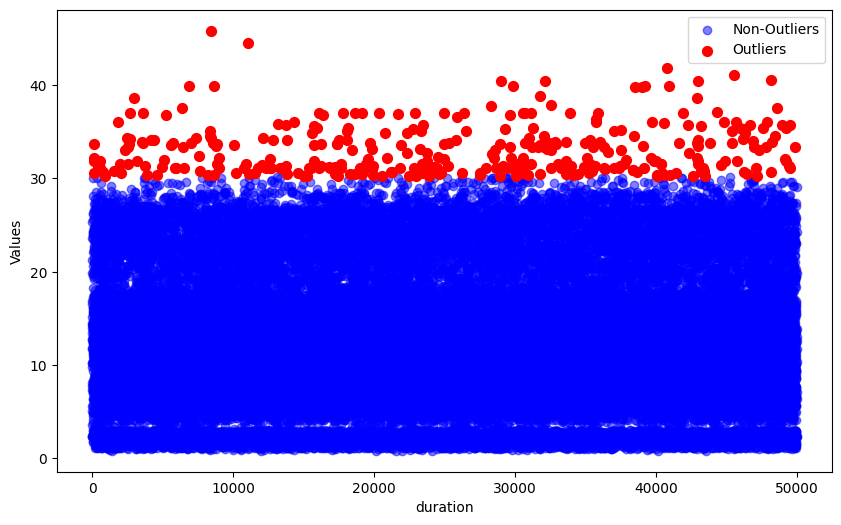

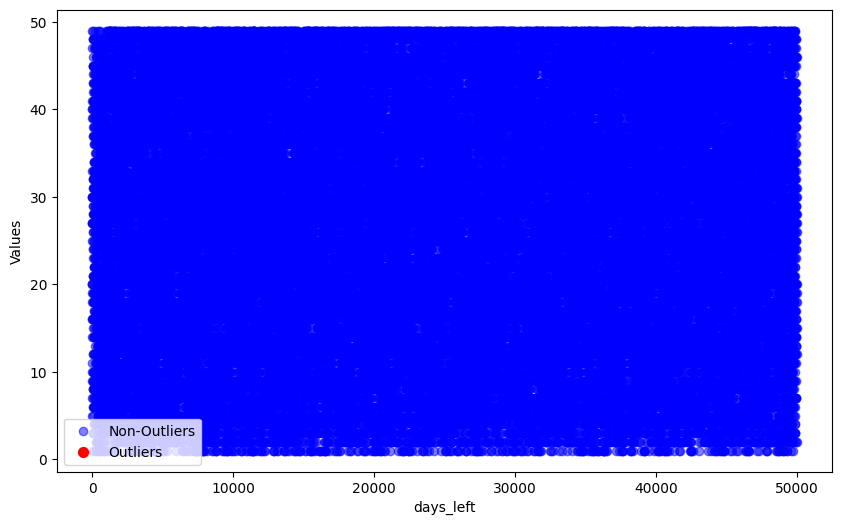

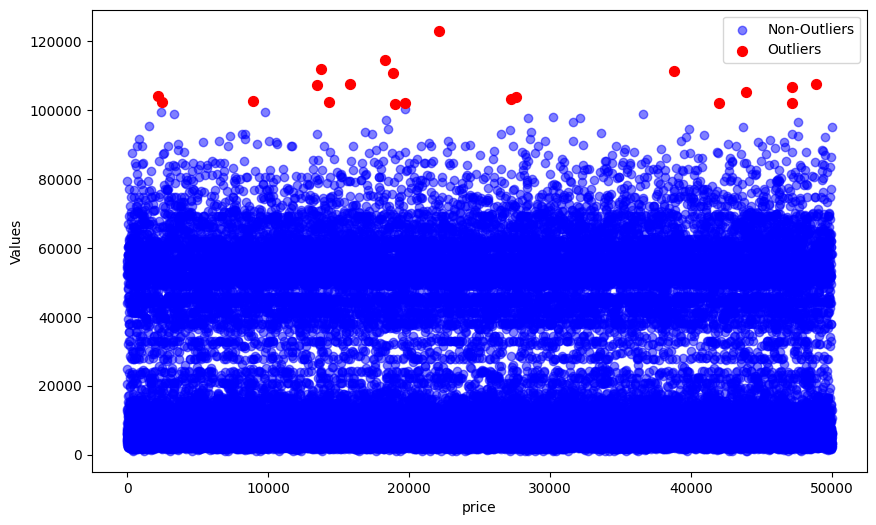

In [4]:
def detectOutliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] < lower_bound) | (df[column] > upper_bound)]

outlier_columns = ['duration', 'days_left', 'price']
for column in outlier_columns:
    outliers = detectOutliers(flight_df, column)
    flight_df = flight_df.drop(outliers.index)
    
    plt.figure(figsize=(10,6))

    plt.scatter(flight_df.index, flight_df[column], color='blue', label='Non-Outliers', alpha=0.5)
    plt.scatter(outliers.index, outliers[column], color='red', label='Outliers', s=50)

    plt.xlabel(column)
    plt.ylabel("Values")
    plt.legend()
    plt.show()

In [5]:
nullValues = flight_df.isnull().sum()
duplicates = flight_df.duplicated().sum()
samples = flight_df.shape[0]

print(nullValues)
print("Null values total: ",nullValues.sum())
print("Duplicates:", duplicates)
print("Samples: ", samples)

airline             1479
flight              1482
source_city         1490
departure_time      1465
stops               1440
arrival_time        1435
destination_city    1484
class               1470
duration            1485
days_left           1487
price               1470
dtype: int64
Null values total:  16187
Duplicates: 36
Samples:  49646


In [6]:
#odstranenie duplicit a null hodnot
flight_df_cleaned = flight_df.dropna()
flight_df_cleaned = flight_df_cleaned.drop_duplicates()

nullValues = flight_df_cleaned.isnull().sum()
duplicates = flight_df_cleaned.duplicated().sum()
samples = flight_df_cleaned.shape[0]

print(nullValues)
print("Null values total: ",nullValues.sum())
print("Duplicates:", duplicates)
print("Samples: ", samples)


airline             0
flight              0
source_city         0
departure_time      0
stops               0
arrival_time        0
destination_city    0
class               0
duration            0
days_left           0
price               0
dtype: int64
Null values total:  0
Duplicates: 0
Samples:  35596


In [7]:
flight_df_cleaned.reset_index(drop=True, inplace=True)
one_hot_encoded_columns = ['airline', 'source_city', 'departure_time', 'arrival_time', 'destination_city', 'class']

flight_df_encoded = pd.get_dummies(flight_df_cleaned,columns=one_hot_encoded_columns, drop_first=False)

flight_df_encoded['stops'] = flight_df_encoded['stops'].map({'zero': 0, 'one': 1, 'two_or_more': 2})

flight_df_encoded['flight'] = flight_df_encoded['flight'].map(flight_df_encoded.groupby('flight')['price'].mean())

In [8]:
flight_df_encoded.reset_index(drop=True, inplace=True)
X = flight_df_encoded.drop('price', axis=1)
Y = flight_df_encoded['price']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state=42)


X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((24917, 36), (24917,), (10679, 36), (10679,))

In [9]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

/home/des/suns/env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/des/suns/env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


R2 score test data:  0.9683062869208504
RMSE test data:  4019.171985302891
R2 score train data:  0.9999873956755265
RMSE test data:  80.66936303927345


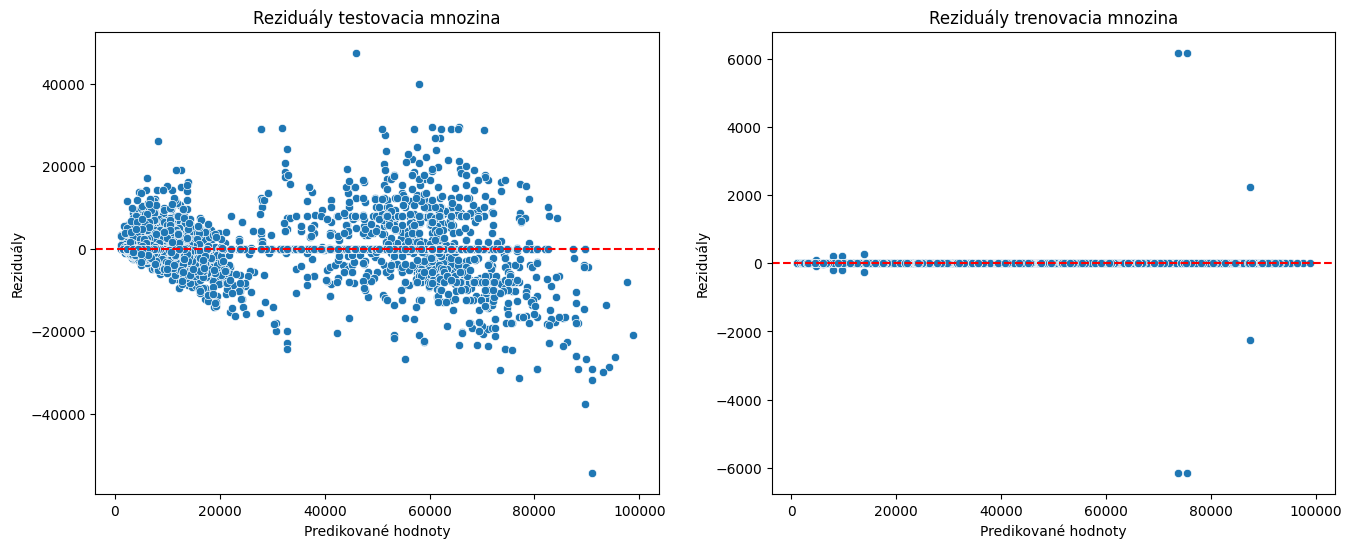

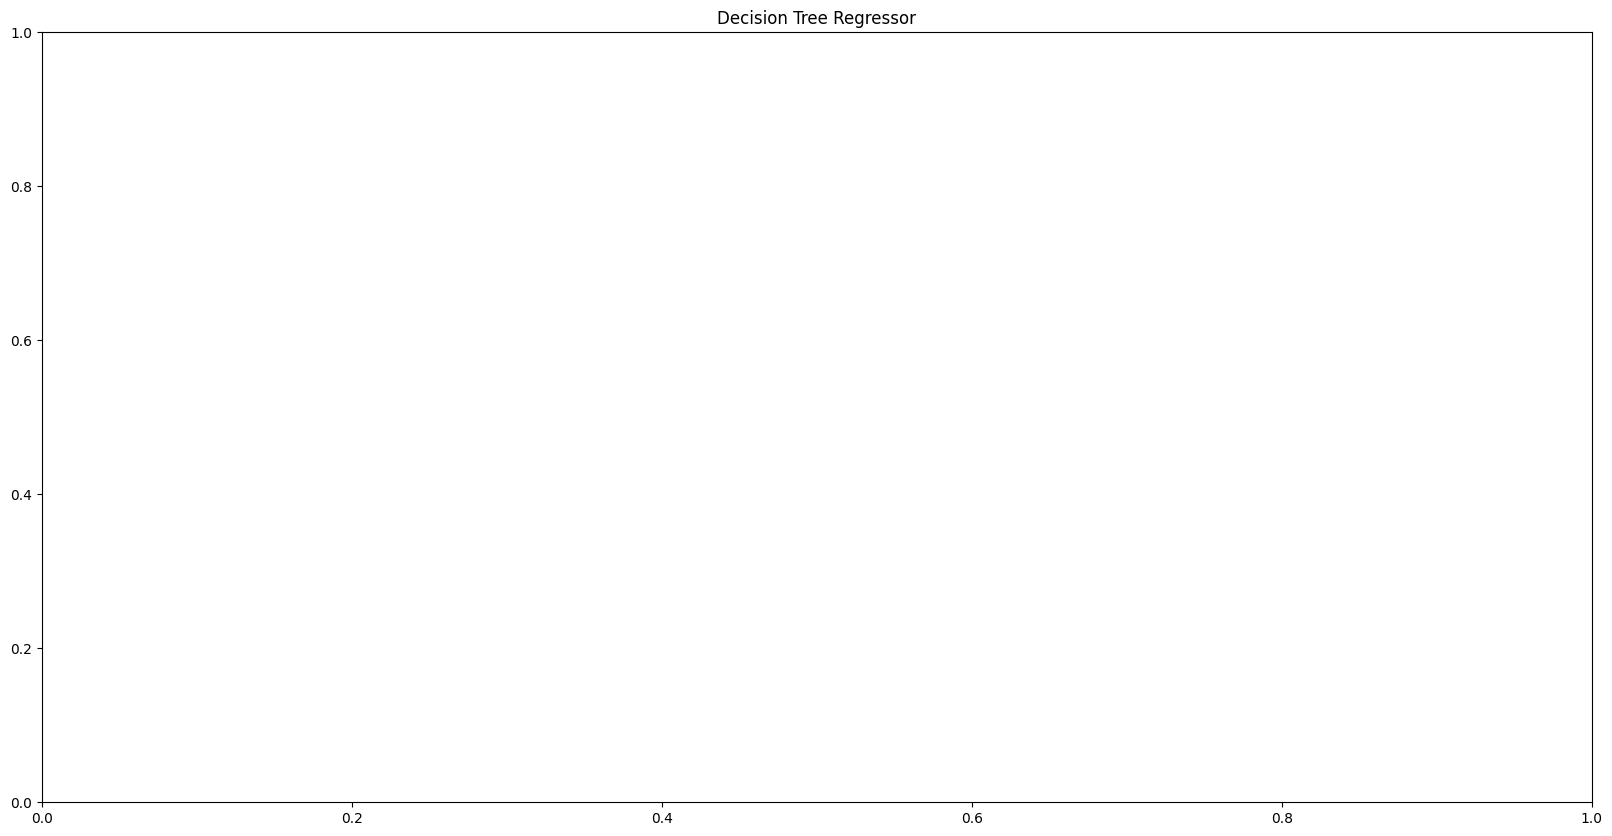

In [19]:
model = DecisionTreeRegressor()
model.fit(X_train, Y_train)

y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)

r2_pred = r2_score(Y_test, y_pred)
rmse_pred = mean_squared_error(Y_test, y_pred, squared=False)
r2_pred_train = r2_score(Y_train, y_pred_train)
rmse_pred_train = mean_squared_error(Y_train, y_pred_train, squared=False)

print("R2 score test data: ", r2_pred)
print("RMSE test data: ", rmse_pred)
print("R2 score train data: ", r2_pred_train)
print("RMSE test data: ", rmse_pred_train)

residuals = Y_test - y_pred
residuals_train = Y_train - y_pred_train

plt.figure(figsize=(16, 6))
plt.subplot(1,2,1)
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predikované hodnoty")
plt.ylabel("Reziduály")
plt.title("Reziduály testovacia mnozina")

plt.subplot(1,2,2)
sns.scatterplot(x=y_pred_train, y=residuals_train)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predikované hodnoty")
plt.ylabel("Reziduály")
plt.title("Reziduály trenovacia mnozina")
plt.show()

plt.figure(figsize=(20, 10))
#plot_tree(model, filled=True, feature_names=X.columns.tolist(), rounded=True)
plt.title("Decision Tree Regressor")
plt.show()

/home/des/suns/env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/des/suns/env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


R2 score test data:  0.9826538764884006
RMSE test data:  2973.3856889019826
R2 score train data:  0.9976476398423646
RMSE test data:  1102.0486019890636


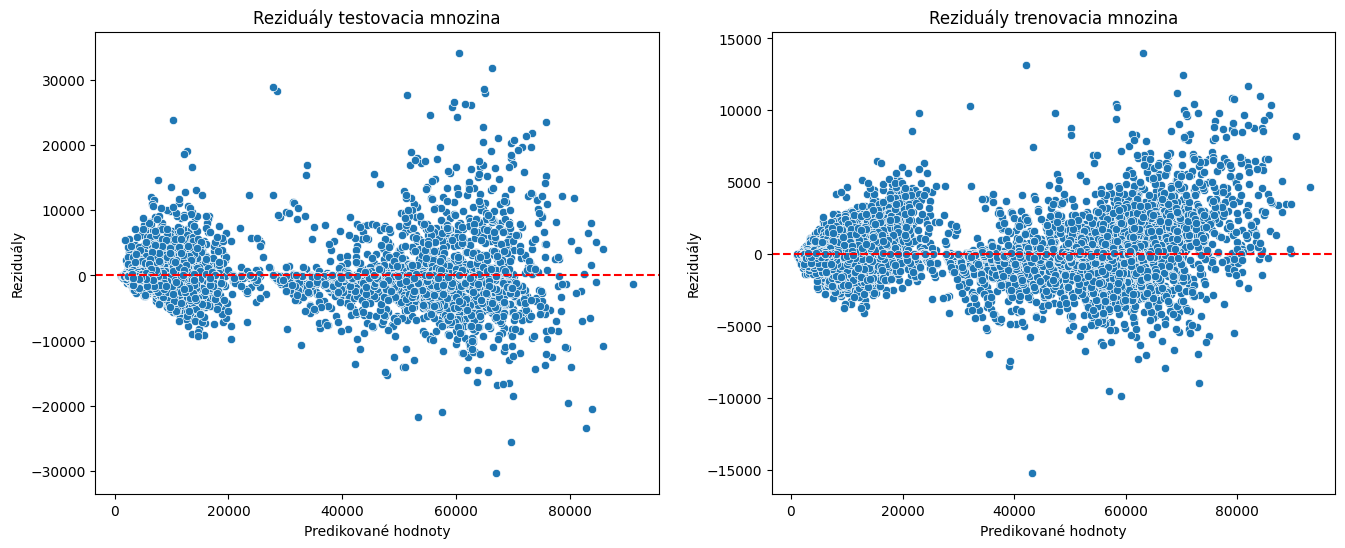

/tmp/ipykernel_400/1912154956.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features['Importance'], y=top_features['Feature'], palette="crest")


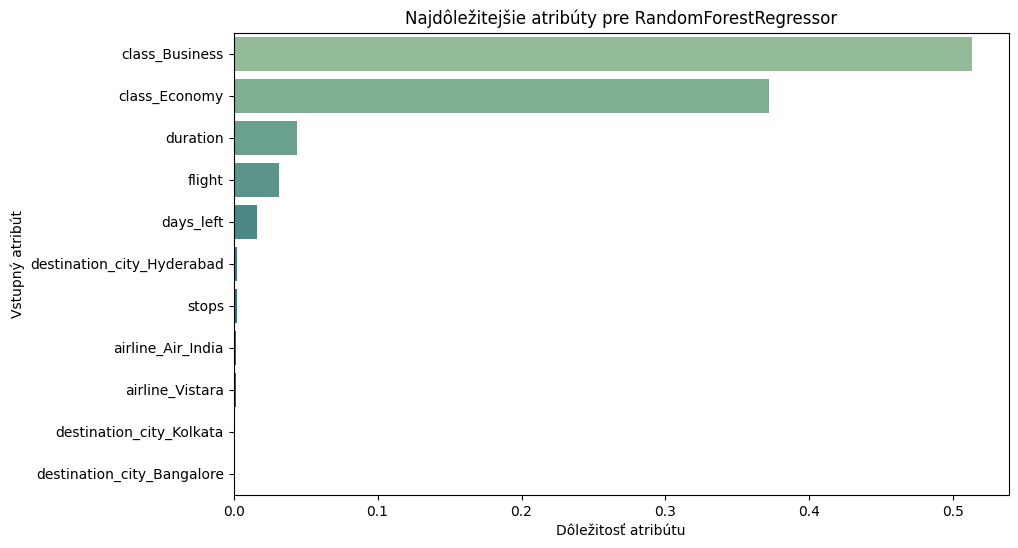

In [10]:
model = RandomForestRegressor()
model.fit(X_train, Y_train)

y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)

r2_pred = r2_score(Y_test, y_pred)
rmse_pred = mean_squared_error(Y_test, y_pred, squared=False)
r2_pred_train = r2_score(Y_train, y_pred_train)
rmse_pred_train = mean_squared_error(Y_train, y_pred_train, squared=False)

print("R2 score test data: ", r2_pred)
print("RMSE test data: ", rmse_pred)
print("R2 score train data: ", r2_pred_train)
print("RMSE test data: ", rmse_pred_train)

residuals = Y_test - y_pred
residuals_train = Y_train - y_pred_train

plt.figure(figsize=(16, 6))
plt.subplot(1,2,1)
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predikované hodnoty")
plt.ylabel("Reziduály")
plt.title("Reziduály testovacia mnozina")

plt.subplot(1,2,2)
sns.scatterplot(x=y_pred_train, y=residuals_train)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predikované hodnoty")
plt.ylabel("Reziduály")
plt.title("Reziduály trenovacia mnozina")
plt.show()


feature_importances = model.feature_importances_

importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

importance_df = importance_df.sort_values(by="Importance", ascending=False)

top_features = importance_df.head(11)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_features['Importance'], y=top_features['Feature'], palette="crest")
plt.xlabel("Dôležitosť atribútu")
plt.ylabel("Vstupný atribút")
plt.title("Najdôležitejšie atribúty pre RandomForestRegressor")
plt.show()


/home/des/suns/env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/des/suns/env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


R2 score test data:  0.9566978324225563
RMSE test data:  4697.911679351974
R2 score train data:  0.959806975262532
RMSE test data:  4555.375541035189


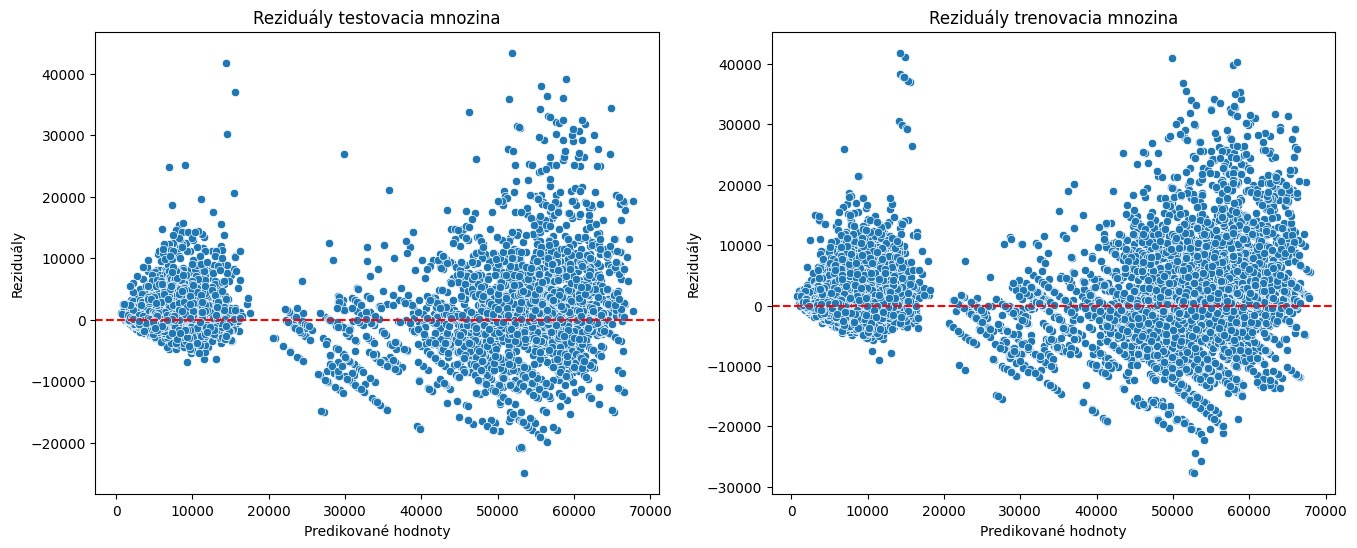

In [11]:
model = SVR(kernel='rbf', C=1000)
model.fit(X_train, Y_train)

y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)

r2_pred = r2_score(Y_test, y_pred)
rmse_pred = mean_squared_error(Y_test, y_pred, squared=False)
r2_pred_train = r2_score(Y_train, y_pred_train)
rmse_pred_train = mean_squared_error(Y_train, y_pred_train, squared=False)
print("R2 score test data: ", r2_pred)
print("RMSE test data: ", rmse_pred)
print("R2 score train data: ", r2_pred_train)
print("RMSE test data: ", rmse_pred_train)

residuals = Y_test - y_pred
residuals_train = Y_train - y_pred_train

plt.figure(figsize=(16, 6))
plt.subplot(1,2,1)
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predikované hodnoty")
plt.ylabel("Reziduály")
plt.title("Reziduály testovacia mnozina")

plt.subplot(1,2,2)
sns.scatterplot(x=y_pred_train, y=residuals_train)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predikované hodnoty")
plt.ylabel("Reziduály")
plt.title("Reziduály trenovacia mnozina")
plt.show()


Num GPUs Available:  1
Epoch 1/400


/home/des/suns/env/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


156/156 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 959952384.0000 - mean_absolute_error: 21043.8457 - val_loss: 937488384.0000 - val_mean_absolute_error: 20826.4238
Epoch 2/400
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 964487552.0000 - mean_absolute_error: 21091.4141 - val_loss: 920536960.0000 - val_mean_absolute_error: 20589.8379
Epoch 3/400
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 933344320.0000 - mean_absolute_error: 20681.3164 - val_loss: 870908096.0000 - val_mean_absolute_error: 19910.9375
Epoch 4/400
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 879803840.0000 - mean_absolute_error: 19968.8594 - val_loss: 779938816.0000 - val_mean_absolute_error: 18638.5234
Epoch 5/400
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 772384768.0000 - mean_absolute_error: 18458.6973 - val_loss: 651737664.0000 - val_mean_absolute_error: 16868.0137
Epoch 6/400
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 622368576.0000 - mean_absolute_error: 16381.9443 - val_loss: 507073376.0000

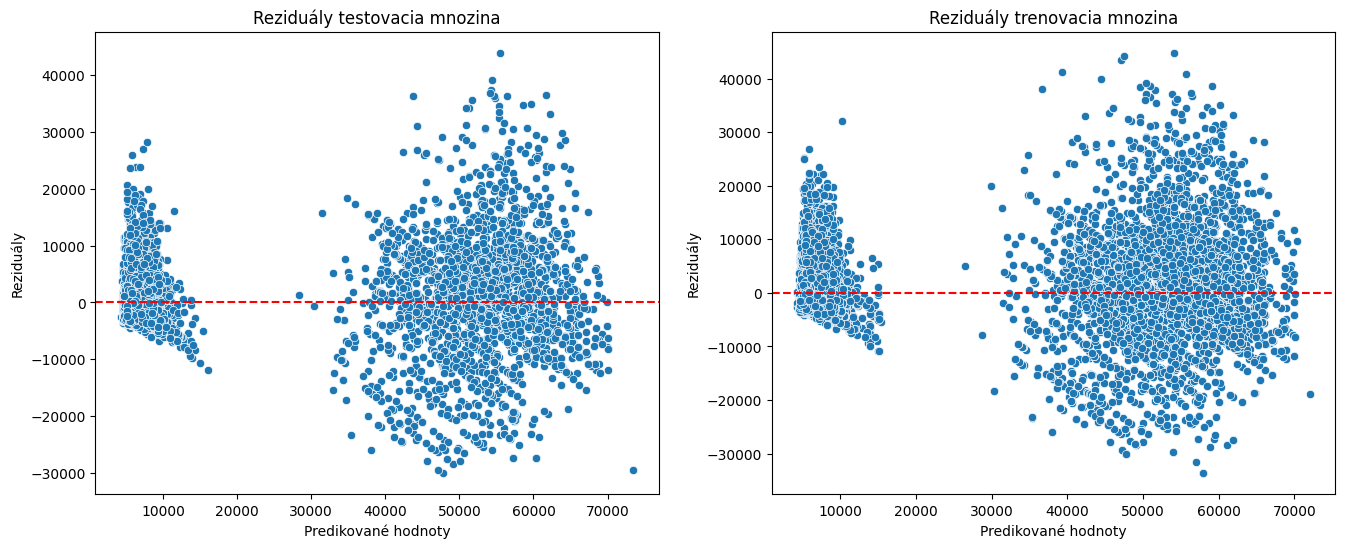

In [34]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
model = tf.keras.Sequential()

model.add(tf.keras.layers.Dense(50, input_shape=(X_train.shape[1],), activation='relu'))
model.add(tf.keras.layers.Dense(20, activation='relu'))
model.add(tf.keras.layers.Dense(1))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, loss='mse', metrics=['mean_absolute_error'])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train, Y_train, epochs=400, batch_size=128, verbose=1, validation_split=0.2, callbacks=[early_stopping])

y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)

mse, mae = model.evaluate(X_test, Y_test)
rmse = math.sqrt(mse)
r2_pred = r2_score(Y_test, y_pred)
mse_train, mae_train =model.evaluate(X_train, Y_train)
rmse_train = math.sqrt(mse)
r2_pred_train = r2_score(Y_train, y_pred_train)
print("R2 score test data: ", r2_pred)
print(f'Test RMSE: {rmse}')
print(f'Test MAE: {mae}' )
print("R2 score train data: ", r2_pred_train)
print(f'Training RMSE: {rmse_train}')
print(f'Train MAE: {mae}' )


residuals = Y_test - y_pred.flatten() 
residuals_train = Y_train - y_pred_train.flatten() 

plt.figure(figsize=(16, 6))
plt.subplot(1,2,1)
sns.scatterplot(x=y_pred.flatten(), y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predikované hodnoty")
plt.ylabel("Reziduály")
plt.title("Reziduály testovacia mnozina")

plt.subplot(1,2,2)
sns.scatterplot(x=y_pred_train.flatten(), y=residuals_train)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predikované hodnoty")
plt.ylabel("Reziduály")
plt.title("Reziduály trenovacia mnozina")
plt.show()


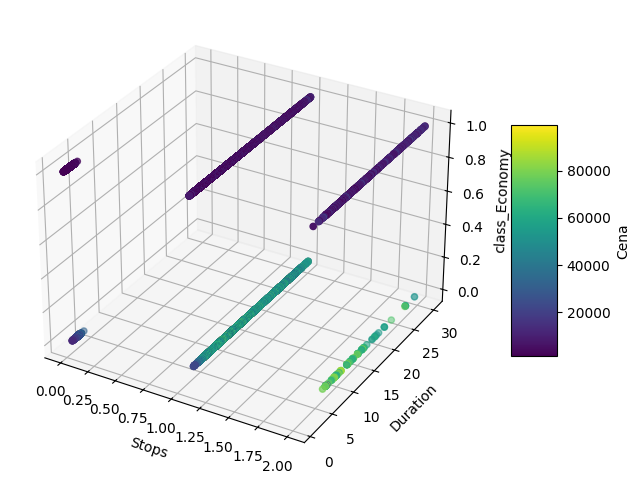

In [ ]:
fig = plt.figure(figsize=(10,6))

ax = fig.add_subplot(111, projection='3d')

x = flight_df_encoded['stops'] 
y = flight_df_encoded['duration'] 
z = flight_df_encoded['class_Economy'] 


scatter = ax.scatter(x, y, z, c=flight_df_encoded['price'], marker='o')
ax.set_xlabel('Stops')
ax.set_ylabel('Duration')
ax.set_zlabel('class_Economy')

cbar = plt.colorbar(scatter, ax=ax, shrink=0.5, aspect=5)
cbar.set_label("Cena")

plt.show()

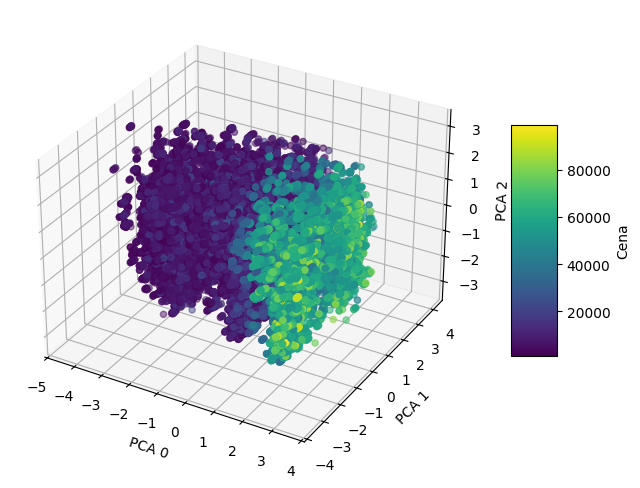

In [ ]:
pca = PCA(n_components=3)
X_scaled = scaler.fit_transform(X)
X_reduced = pca.fit_transform(X_scaled)

fig = plt.figure(figsize=(10,6))

ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(X_reduced[:,0], X_reduced[:, 1], X_reduced[:, 2], c=flight_df_cleaned['price'], marker='o')
ax.set_xlabel('PCA 0')
ax.set_ylabel('PCA 1')
ax.set_zlabel('PCA 2')

cbar = plt.colorbar(scatter, ax=ax, shrink=0.5, aspect=5)
cbar.set_label("Cena")

plt.show()


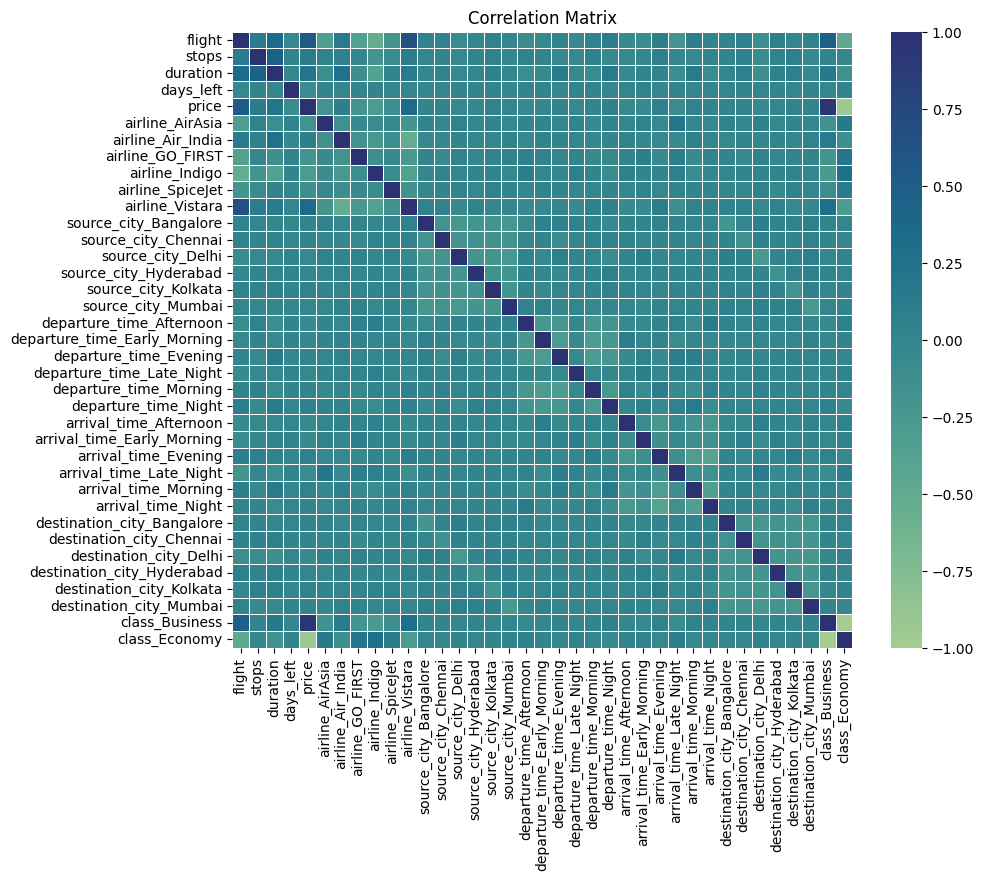

Korelácie s cenou (price), zoradené od najvyššej po najnižšiu:
price                           1.000000
class_Business                  0.939673
flight                          0.530931
airline_Vistara                 0.355084
duration                        0.217523
stops                           0.121570
airline_Air_India               0.078203
arrival_time_Evening            0.062312
departure_time_Night            0.049603
arrival_time_Morning            0.034830
destination_city_Kolkata        0.025620
source_city_Chennai             0.024321
source_city_Kolkata             0.023735
departure_time_Morning          0.016268
destination_city_Chennai        0.015643
source_city_Bangalore           0.015287
arrival_time_Night              0.015041
destination_city_Mumbai         0.013438
departure_time_Evening          0.011668
destination_city_Bangalore      0.009794
source_city_Mumbai             -0.002643
destination_city_Hyderabad     -0.006712
source_city_Hyderabad          -0.0

/home/des/suns/env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/des/suns/env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


R2 score test data:  0.965937426921089
RMSE test data:  4166.666637837239
R2 score train data:  0.9835976895139512
RMSE test data:  2910.0560553885402


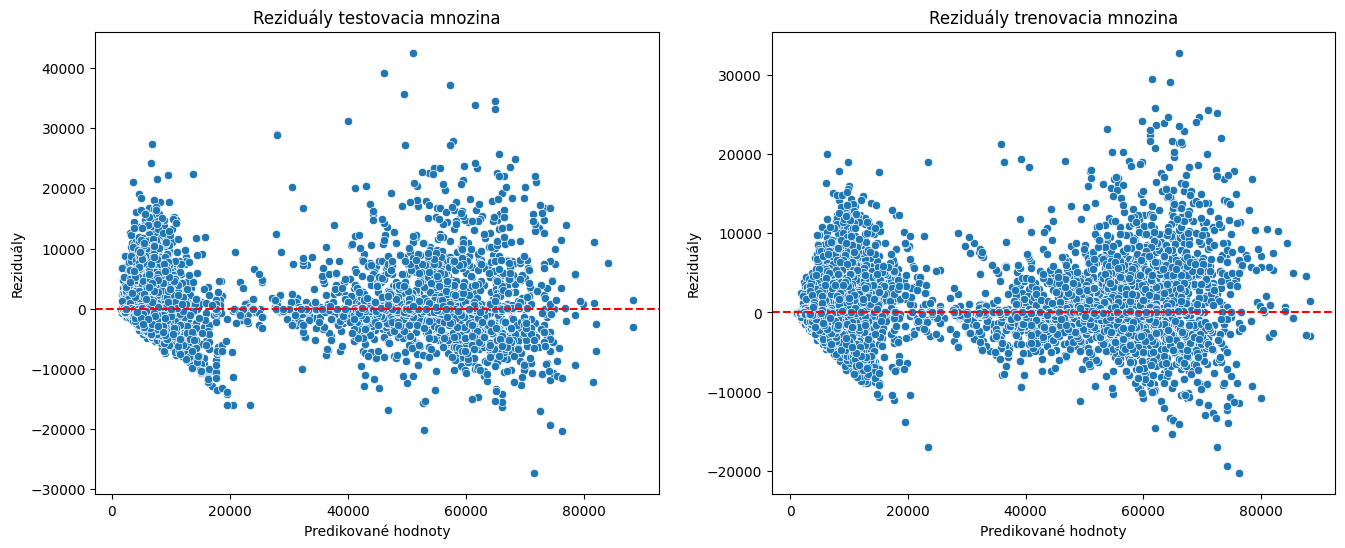

In [ ]:
correlation_matrix = flight_df_encoded.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='crest', linewidths=0.5).set(title="Correlation Matrix")
plt.show()

correlations_with_price = correlation_matrix['price'].sort_values(ascending=False)
selected_features = correlations_with_price.index[1:5].tolist()

print("Korelácie s cenou (price), zoradené od najvyššej po najnižšiu:")
print(correlations_with_price)

flight_df_encoded.reset_index(drop=True, inplace=True)
X = flight_df_encoded[selected_features]
Y = flight_df_encoded['price']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state=42)

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = RandomForestRegressor()
model.fit(X_train, Y_train)

y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)

r2_pred = r2_score(Y_test, y_pred)
rmse_pred = mean_squared_error(Y_test, y_pred, squared=False)
r2_pred_train = r2_score(Y_train, y_pred_train)
rmse_pred_train = mean_squared_error(Y_train, y_pred_train, squared=False)

print("R2 score test data: ", r2_pred)
print("RMSE test data: ", rmse_pred)
print("R2 score train data: ", r2_pred_train)
print("RMSE test data: ", rmse_pred_train)

residuals = Y_test - y_pred
residuals_train = Y_train - y_pred_train

plt.figure(figsize=(16, 6))
plt.subplot(1,2,1)
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predikované hodnoty")
plt.ylabel("Reziduály")
plt.title("Reziduály testovacia mnozina")

plt.subplot(1,2,2)
sns.scatterplot(x=y_pred_train, y=residuals_train)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predikované hodnoty")
plt.ylabel("Reziduály")
plt.title("Reziduály trenovacia mnozina")
plt.show()


/home/des/suns/env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/des/suns/env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


R2 score test data:  0.9575612306162951
RMSE test data:  4650.840231156436
R2 score train data:  0.9939223888032825
RMSE test data:  1771.3945215504086


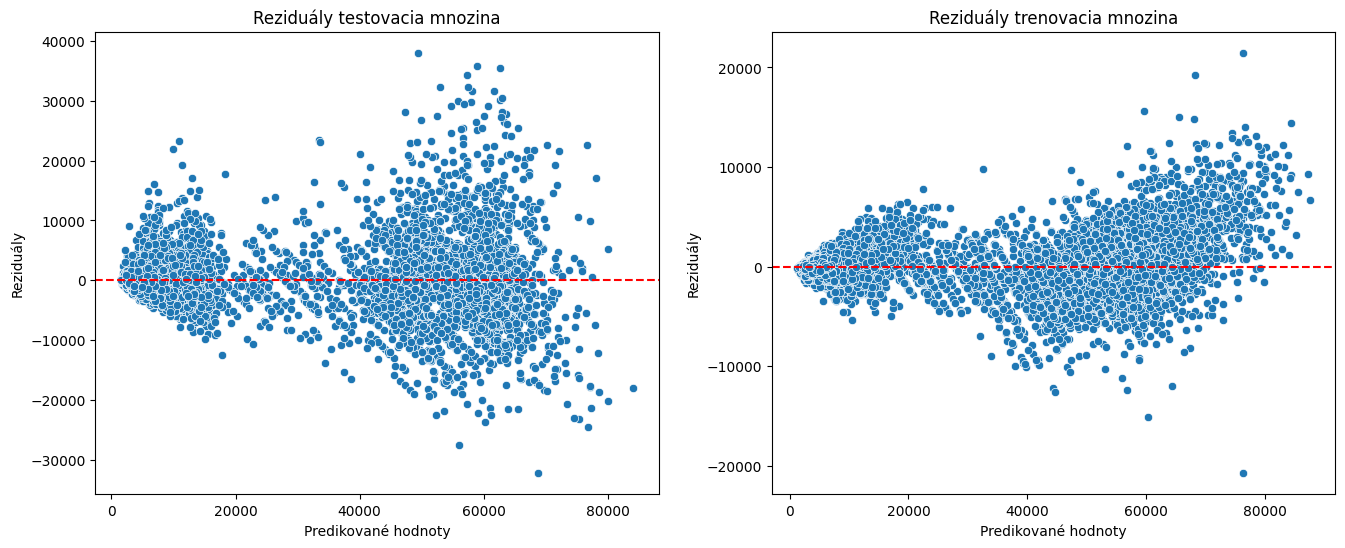

In [ ]:
flight_df_encoded.reset_index(drop=True, inplace=True)
X = flight_df_encoded[['class_Business', 'class_Economy', 'duration', 'flight', 'days_left']]
Y = flight_df_encoded['price']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state=42)

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = RandomForestRegressor()
model.fit(X_train, Y_train)

y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)

r2_pred = r2_score(Y_test, y_pred)
rmse_pred = mean_squared_error(Y_test, y_pred, squared=False)
r2_pred_train = r2_score(Y_train, y_pred_train)
rmse_pred_train = mean_squared_error(Y_train, y_pred_train, squared=False)

print("R2 score test data: ", r2_pred)
print("RMSE test data: ", rmse_pred)
print("R2 score train data: ", r2_pred_train)
print("RMSE test data: ", rmse_pred_train)

residuals = Y_test - y_pred
residuals_train = Y_train - y_pred_train

plt.figure(figsize=(16, 6))
plt.subplot(1,2,1)
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predikované hodnoty")
plt.ylabel("Reziduály")
plt.title("Reziduály testovacia mnozina")

plt.subplot(1,2,2)
sns.scatterplot(x=y_pred_train, y=residuals_train)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predikované hodnoty")
plt.ylabel("Reziduály")
plt.title("Reziduály trenovacia mnozina")
plt.show()


/home/des/suns/env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/des/suns/env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


R2 score test data:  0.9721948931259894
RMSE test data:  3764.543448789716
R2 score train data:  0.9962446197819097
RMSE test data:  1392.4377780615746


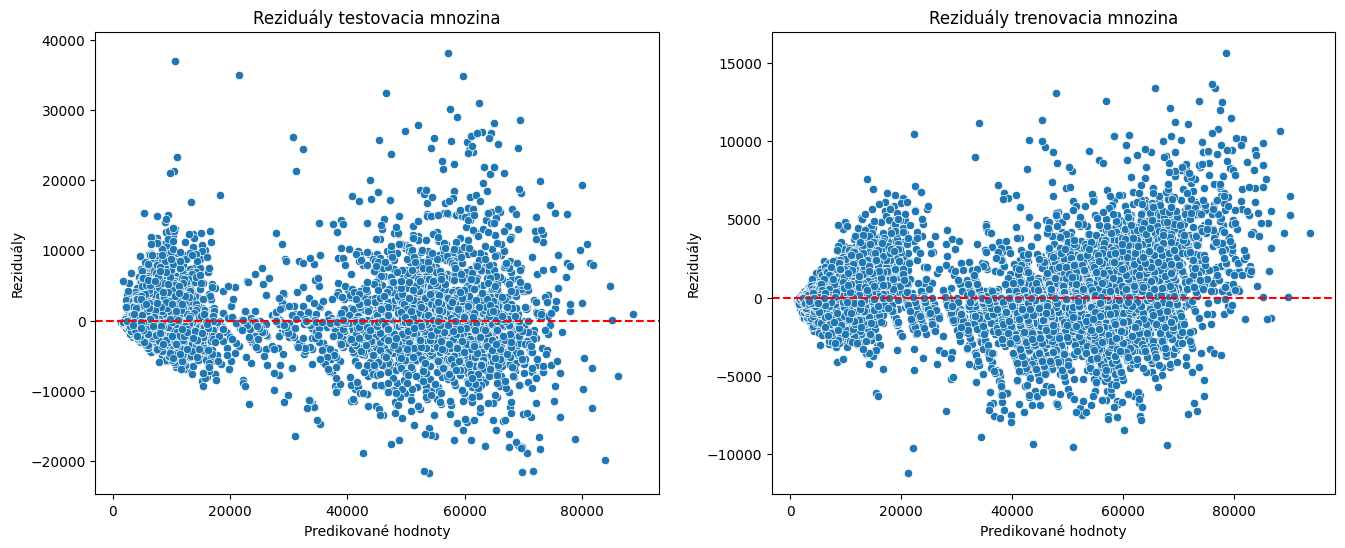

In [ ]:
pca = PCA(n_components=0.85)
X_scaled = scaler.fit_transform(X)
X_reduced = pca.fit_transform(X_scaled)


X_train, X_test, Y_train, Y_test = train_test_split(X_reduced, Y, test_size = 0.3, random_state=42)


model = RandomForestRegressor()
model.fit(X_train, Y_train)

y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)

r2_pred = r2_score(Y_test, y_pred)
rmse_pred = mean_squared_error(Y_test, y_pred, squared=False)
r2_pred_train = r2_score(Y_train, y_pred_train)
rmse_pred_train = mean_squared_error(Y_train, y_pred_train, squared=False)

print("R2 score test data: ", r2_pred)
print("RMSE test data: ", rmse_pred)
print("R2 score train data: ", r2_pred_train)
print("RMSE test data: ", rmse_pred_train)

residuals = Y_test - y_pred
residuals_train = Y_train - y_pred_train

plt.figure(figsize=(16, 6))
plt.subplot(1,2,1)
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predikované hodnoty")
plt.ylabel("Reziduály")
plt.title("Reziduály testovacia mnozina")

plt.subplot(1,2,2)
sns.scatterplot(x=y_pred_train, y=residuals_train)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predikované hodnoty")
plt.ylabel("Reziduály")
plt.title("Reziduály trenovacia mnozina")
plt.show()


/tmp/ipykernel_395/1213880158.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(temperature_by_season, x='airline', y='duration', palette="crest").set(title="Average flight duration by airline", ylabel="Average Flight Duration")


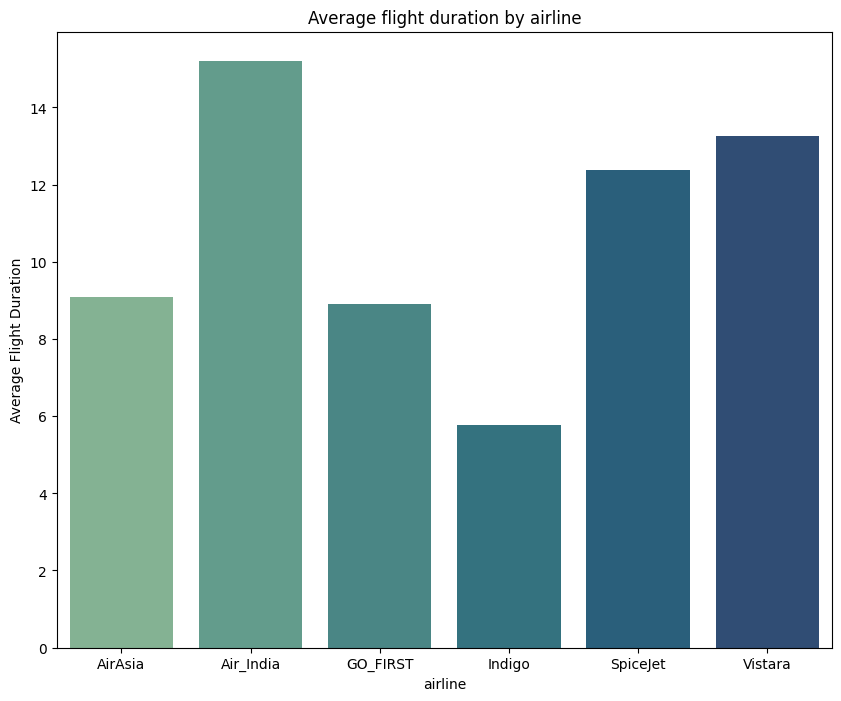

In [ ]:
temperature_by_season = flight_df_cleaned.groupby('airline')['duration'].mean().reset_index()

plt.figure(figsize=(10, 8))
sns.barplot(temperature_by_season, x='airline', y='duration', palette="crest").set(title="Average flight duration by airline", ylabel="Average Flight Duration")
plt.show()

<Figure size 1000x800 with 0 Axes>

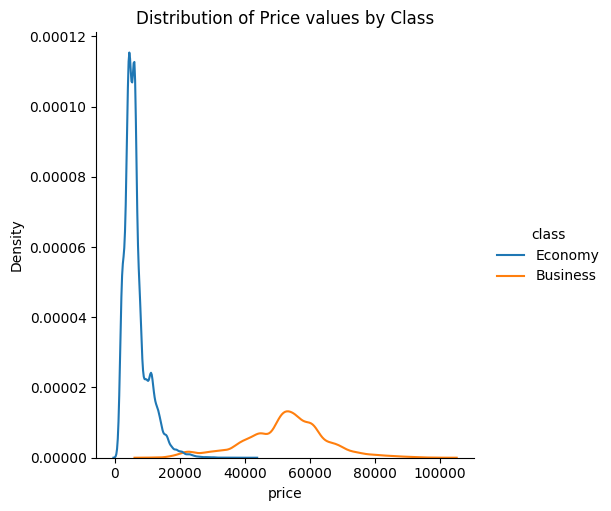

In [ ]:
plt.figure(figsize=(10, 8))
sns.displot(flight_df_cleaned, x='price', hue="class", kind="kde").set(title="Distribution of Price values by Class")
plt.show()

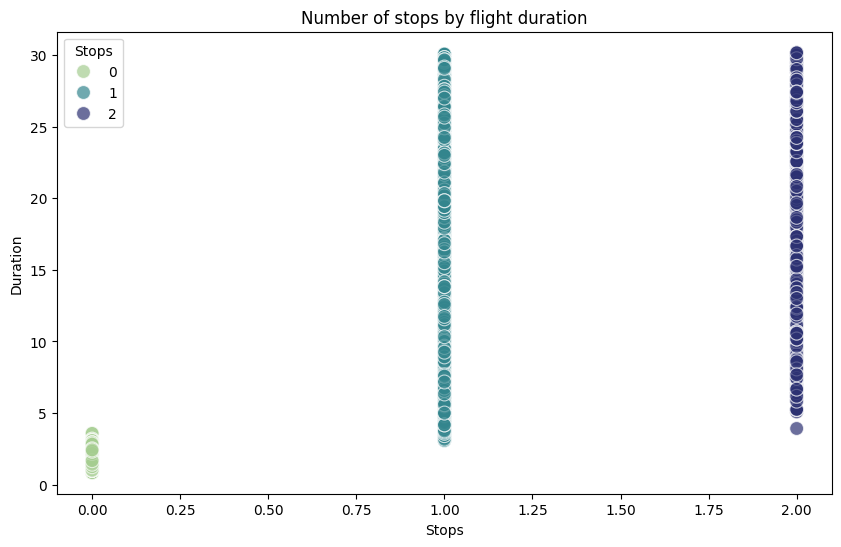

In [15]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=flight_df_encoded, x='stops', y='duration', hue='stops', palette='crest', s=100, alpha=0.7)
plt.title("Number of stops by flight duration")
plt.xlabel("Stops")
plt.ylabel("Duration")
plt.legend(title="Stops", loc='upper left')
plt.show()

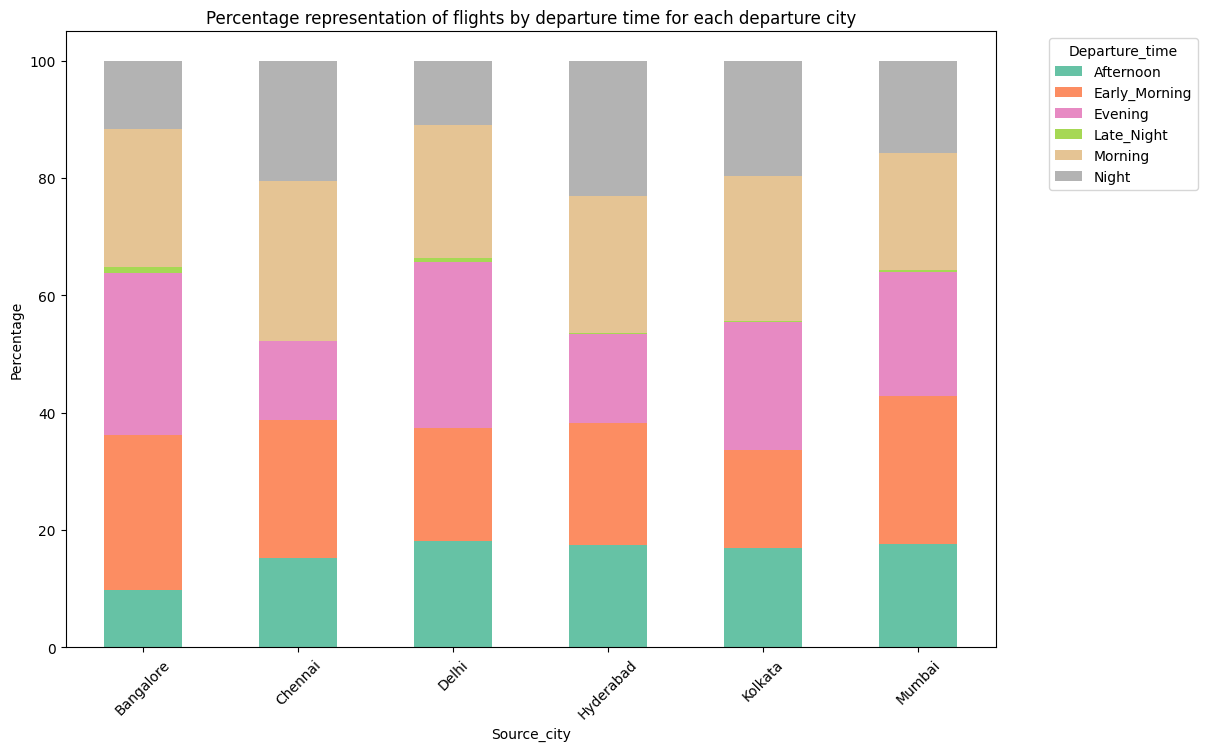

In [16]:
departure_counts = flight_df_cleaned.groupby(['source_city', 'departure_time']).size().unstack(fill_value=0)
departure_percent = departure_counts.div(departure_counts.sum(axis=1), axis=0) * 100 

departure_percent.plot(kind='bar', stacked=True, figsize=(12, 8), cmap="Set2")
plt.title("Percentage representation of flights by departure time for each departure city")
plt.xlabel("Source_city")
plt.ylabel("Percentage")
plt.legend(title="Departure_time", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.show()

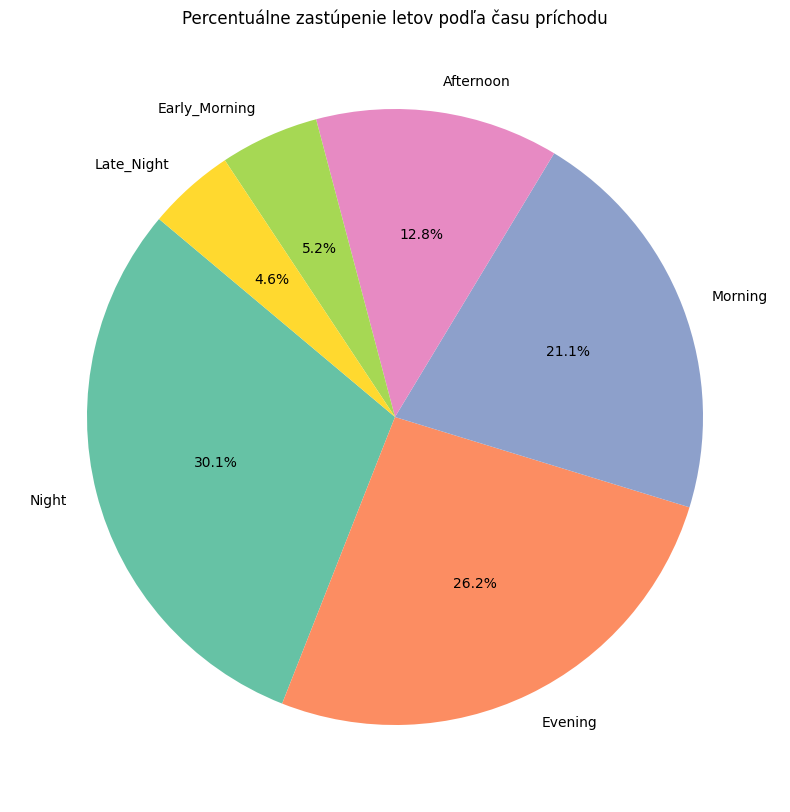

In [64]:
arrival_time_counts = flight_df_cleaned['arrival_time'].value_counts(normalize=True) * 100  # Prevod na percentá

plt.figure(figsize=(10, 10))
plt.pie(arrival_time_counts, labels=arrival_time_counts.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Set2.colors)
plt.title("Percentuálne zastúpenie letov podľa času príchodu")
plt.show()